# Two dimensional unequal sampling generalized prolates

This example is not unlike the 2D example of Bronez. We don't have the data, but here goes.

In [1]:
using FFTW, IterTools, Plots, LinearAlgebra, KrylovKit, FINUFFT
using Slepians

""" 

    dfn(x, y, bet)

The underlying Kernel function, equation 22-23 in Chave

# Arguments
    - `x::Number` 1-dimensional location
    - `y::Number` 1-dimensional location
    - `bet::Number` 1-dimensional bandwidth

# Outputs
    - Kernel evaluated between the two points x, y
"""
function dfn(x, y, bet)
  x == y && return 2*bet
  sin(2 * pi * bet * (x - y))/(pi * (x - y))
end

""" 

    efn(x, y, f)

The FT matrix

# Arguments
    - `x::Vector` d-dimensional location
    - `y::Vector` d-dimensional location
    - `f::Vector` d-dimensional frequency

# Outputs
    - Frequency-dependent kernel evaluated between the two points x, y
"""
function efn(x, y, f)
    x == y && return 1.0
    f == 0.0 && return 1.0
    exp(-2.0im * pi * f * (x - y))
end

# Product of efn and dfn
function bfn(x, y, f, bet)
    efn(x, y, f) * dfn(x, y, bet)
end

bfn (generic function with 1 method)

# Warmup: Missing data problem in 1D

In [2]:
NN = 256
tt = (1.0:NN).^(1.05)

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.0

RA = [dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true)

([0.9999999999947413], [[-4.5646457391701055e-5, -0.0003119043131809132, -0.0012751542677229195, -0.003922720167399076, -0.00990720973133893, -0.02147486871153205, -0.0409990968255647, -0.070084732836495, -0.1084494170089764, -0.15306799937151014  …  0.0027808436515149412, 0.00783398190170995, 0.010149342252519603, 0.009594140188824337, 0.007230972998744179, 0.004441882010425221, 0.0022056828114765566, 0.000853071457578921, 0.000235098558537648, 3.599227189947362e-5]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (4.978125767592955e-8,).
)

In [3]:
using Multitaper

lam_orth, u_orth = Multitaper.gpss_orth(fA, 1, tt, 0.0, beta = fB)

lam, u = Multitaper.gpss(fA, 1, tt, 0.0, beta = fB)

┌ Info: Precompiling Multitaper [a81958ac-9ec9-4086-814d-3ae87249a5e8]
└ @ Base loading.jl:1278


([1.000000000000005], Complex{Float64}[-1.3815763111587405e-7 - 0.0im; -1.3973396998520222e-6 - 0.0im; … ; -3.6009265383039307e-7 - 0.0im; -2.5803159384208916e-31 - 0.0im], Cholesky{Complex{Float64},Array{Complex{Float64},2}}(Complex{Float64}[1.0 + 0.0im -0.06534534398152574 - 0.0im … -0.0009102308338316301 - 0.0im 0.0005697795924405583 + 0.0im; 1.0 + 0.0im 0.9978627090035663 + 0.0im … 0.000773787309168558 + 0.0im -0.000688105497034729 - 0.0im; … ; 1.0 + 0.0im 1.0 + 0.0im … 0.9710556103148197 + 0.0im -0.2005260071180715 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im … 1.0 + 0.0im 0.9710520812214699 + 0.0im], 'U', 0))

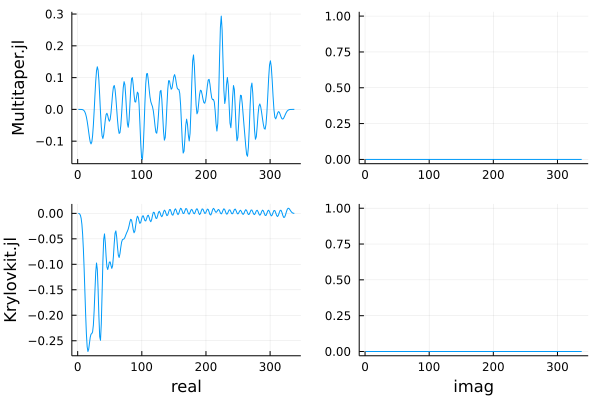

In [4]:
plot(plot(tt, real.(u)), plot(tt, imag.(u)), plot(tt, real.(neig[2][1])), plot(tt, imag.(neig[2][1])),
    layout = (2,2), xlabel = ["" "" "real" "imag"], ylabel = ["Multitaper.jl" "" "Krylovkit.jl" ""], 
    legend = false)

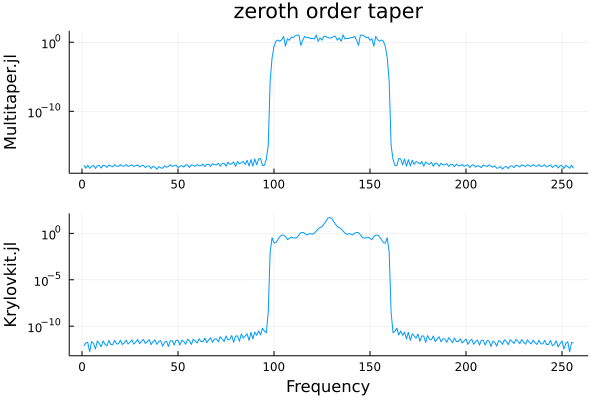

In [5]:
K = 1
w = fA
freqs = LinRange(-0.5, 0.5, NN+1)[1:NN]

ftsleps = mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, collect(freqs))),hcat, 1:K)

ftsleps2 = abs2.(nufft1d3(2*pi*tt, ComplexF64.(neig[2][1]), -1, 1e-15, collect(freqs)))

plot(plot(ftsleps, yscale = :log10), plot(ftsleps2, yscale = :log10), layout = (2,1), legend = false,
    title = ["zeroth order taper" ""], xlabel = ["" "Frequency"], ylabel = ["Multitaper.jl" "Krylovkit.jl"])

# Warmup: Missing data problem in 2D

This is like the data in the Chave paper, only 2D. Gaps. 

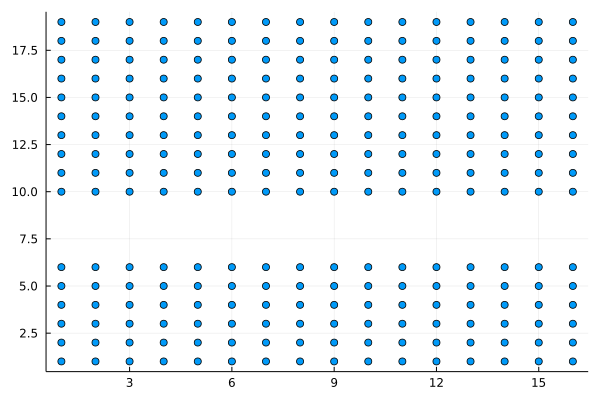

In [6]:
N1 = 16
N2 = 16
t1 = collect(1:N1)
t2 = collect(1:(N2 + 3))[vcat(collect(1:6), collect(10:19))]

mdpts = [(r,t) for r in t1 for t in t2]
mdlocs = [[r,t] for r in t1 for t in t2]

scatter(mdpts, legend = false)

In [7]:
fB = 1.0/2 
fA = 1.0/8 

RA = [dfn(xy..., fA) for xy in IterTools.product(mdlocs, mdlocs)]
RB = [dfn(xy..., fB) for xy in IterTools.product(mdlocs, mdlocs)]

gs = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

LoadError: [91mMethodError: no method matching sin(::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  sin([91m::BigFloat[39m) at mpfr.jl:727[39m
[91m[0m  sin([91m::Missing[39m) at math.jl:1197[39m
[91m[0m  sin([91m::Complex{Float16}[39m) at math.jl:1145[39m
[91m[0m  ...[39m

In [8]:
heatmap(t1, t2, reshape(gs[2][1], (16, 16)), title = "Largest eigenvector (k=0)")

LoadError: [91mUndefVarError: gs not defined[39m

# General problem: Unequal spacing in array

Here is an array similar to the example in the original Bronez paper. 

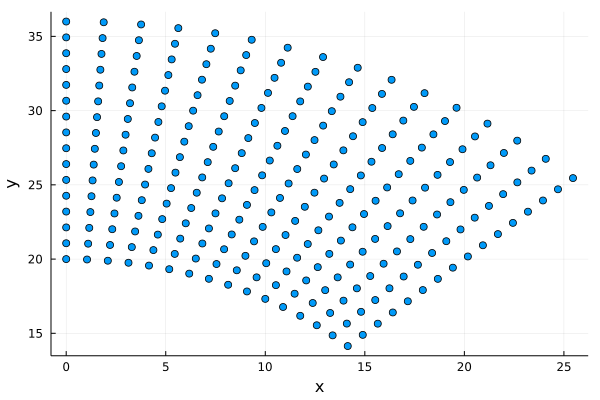

In [9]:
# Set up the array
N1 = 16
N2 = 16

# generate 32 ocncentric circles
rad = collect(LinRange(20,36.0,N1))
thet = collect(LinRange(0.0,45,N2)*pi/180)

pts1 = [(r*sin(t), r*cos(t)) for r in rad for t in thet]

locs1 = [[r*sin(t), r*cos(t)] for r in rad for t in thet]

scatter(pts1, legend = false, xlabel="x", ylabel="y")

In [10]:
# Get the RA and RB matrices, simplifications are provided by Chave, 2020 p 8
d = 2

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.1

RA = [dfn(xy..., fA) for xy in IterTools.product(locs1, locs1)]
RB = [bfn(xy..., [fB, f]) for xy in IterTools.product(locs1, locs1)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

LoadError: [91mMethodError: no method matching sin(::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  sin([91m::BigFloat[39m) at mpfr.jl:727[39m
[91m[0m  sin([91m::Missing[39m) at math.jl:1197[39m
[91m[0m  sin([91m::Complex{Float16}[39m) at math.jl:1145[39m
[91m[0m  ...[39m

In [11]:
xx = hcat(locs1...)

2×256 Array{Float64,2}:
  0.0   1.04672   2.09057   3.12869  …  21.1603  22.6555  24.0887  25.4558
 20.0  19.9726   19.8904   19.7538      29.1246  27.9773  26.7532  25.4558

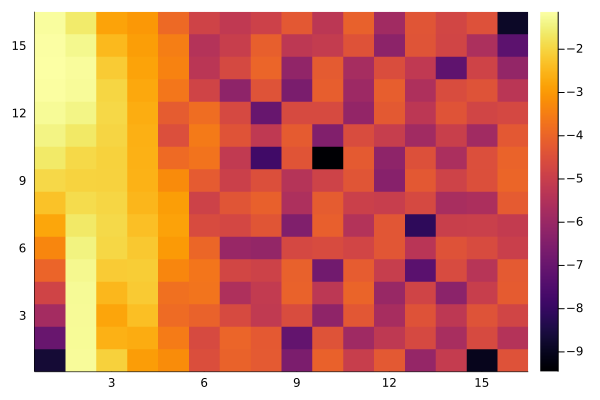

In [12]:
# This is deformed though, so it is hard to visualize with a heatmap
heatmap(log10.(abs2.(reshape(neig[2][1], (16, 16)))))

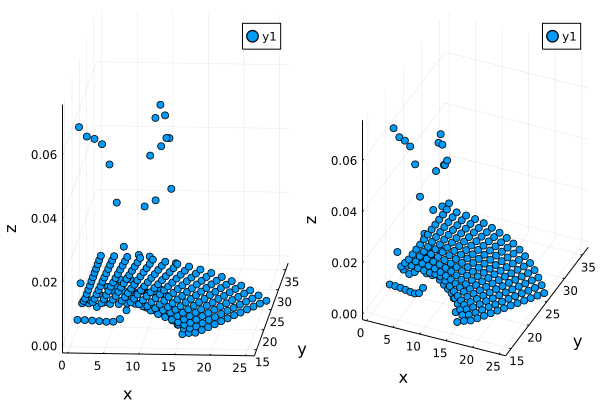

In [13]:
# could do a mesh too
pa = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (10, 35), xlabel = "x", ylabel = "y", zlabel="z")

pb = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (30, 50), xlabel = "x", ylabel = "y", zlabel="z")

plot(pa, pb, layout = (1,2))

In [14]:
freqs1 = LinRange(-1, 1.0, N1)
freqs2 = LinRange(-1, 1.0, N2)

ff = vcat([[xy[1] xy[2]] for xy in IterTools.product(freqs1, freqs2)][:]...)

XX = abs2.(nufft2d1(2*pi*(xx[1,:] .- 12.5)/25., 2*pi*(xx[2,:] .- 12.5)/25., 
        ComplexF64.(neig[2][1]), -1, 1e-15, 2*N1, 2*N2))

#=
nufft2d3(xj      :: Array{Float64}, 
         yj      :: Array{Float64},
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         sk      :: Array{Float64},
         tk      :: Array{Float64}
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}
=#

#=
nufft2d1(xj      :: Array{Float64}, 
         yj      :: Array{Float64}, 
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         ms      :: Integer,
         mt      :: Integer,
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}=#

32×32 Array{Float64,2}:
 1.92984     1.51775     0.856989   …  3.01088     5.11654    5.53324
 3.75098     1.67436     0.69335       1.15346     1.60348    3.41458
 3.56231     2.16082     1.28327       0.366404    1.44231    1.37062
 4.8496      2.7815      1.20988       0.362345    0.206064   0.501154
 4.11236     2.74107     2.02382       0.0789778   0.218627   0.256091
 4.19431     3.20701     2.05891    …  0.198255    0.141304   0.0372095
 2.12481     2.21077     1.95694       0.0679178   0.0201647  0.097658
 1.19979     1.35905     1.26175       0.0531922   0.10051    0.0511644
 0.158562    0.226642    0.467679      0.114688    0.0191106  0.00262109
 0.171127    0.0887721   0.0467535     0.00810133  0.0318877  0.0788607
 0.21006     0.0432837   0.0124409  …  0.0586066   0.0772574  0.0159454
 0.27862     0.190393    0.0235261     0.0694641   0.0066877  0.0607173
 0.509372    0.544434    0.74685       0.0121929   0.124385   0.0929581
 ⋮                                  ⋱           

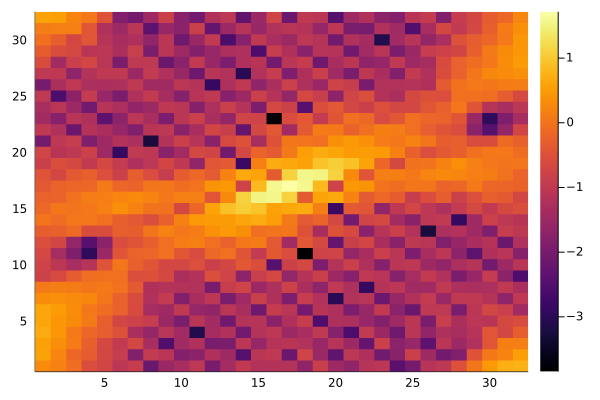

In [15]:
heatmap(log10.(XX))